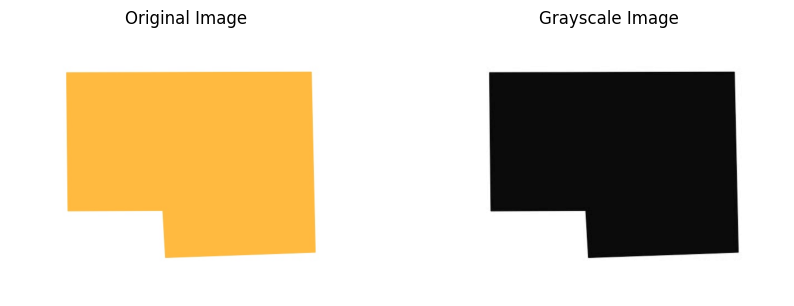

In [1]:
import cv2
from matplotlib import pyplot as plt


# Load the image
image_path = 'E7-images/0001.jpg'  # Replace with the path to your image
image = cv2.imread(image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Display the original and grayscale images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gray_image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

plt.show()
# Replace with the path to your image
image = cv2.imread(image_path)

In [2]:
import os
import cv2

# Define the path to the directory containing the original images
original_images_dir = 'E7-images'

# Define the path to the directory where you'll save the resized images
resized_images_dir = 'resized_images'

# Ensure the directory for resized images exists
os.makedirs(resized_images_dir, exist_ok=True)

# Define the desired dimensions for resized images
desired_width = 320  # Adjust as needed
desired_height = 240  # Adjust as needed

# Resize images
for filename in os.listdir(original_images_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(original_images_dir, filename)
        image = cv2.imread(image_path)
        resized_image = cv2.resize(image, (desired_width, desired_height), interpolation=cv2.INTER_AREA)
        resized_image_path = os.path.join(resized_images_dir, filename)
        cv2.imwrite(resized_image_path, resized_image)


In [3]:
import csv
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

def is_image_file(file_path):
  """Checks if the given path points to an image file.

  Args:
      file_path: Path to the file.

  Returns:
      True if the path points to an image file, False otherwise.
  """

  # Get the file extension
  ext = os.path.splitext(file_path)[1].lower()
  # Define a list of common image extensions
  image_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".gif"]
  return ext in image_extensions

def extract_features(image_path):
    """Extracts shape features from an image.

    Args:
        image_path: Path to the image file.

    Returns:
        A list of features, including area, perimeter, and Hu moments.
    """

    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Edge detection
    edges = cv2.Canny(gray, 100, 200)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    features = []
    for cntr in contours:
        # Area
        area = cv2.contourArea(cntr)

        # Perimeter
        perimeter = cv2.arcLength(cntr, True)

        # Hu moments
        moments = cv2.moments(cntr)
        hu_moments = cv2.HuMoments(moments).flatten()

        # Combine features
        features.append([area, perimeter, *hu_moments])

    return features



def process_image_folder(folder_path):
    """Extracts features from all images in a folder.

    Args:
        folder_path: Path to the folder containing images.

    Returns:
        A list of features for all images in the folder.
    """

    all_features = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if is_image_file(file_path):  # Use the function from previous explanation
            features = extract_features(file_path)
            if features is not None:
                all_features.extend(features)  # Combine features from all images
    return all_features

def save_features_to_csv(features, labels,file_names, output_file_path):
    """Saves extracted features and predicted labels to a CSV file."""
    with open(output_file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)

        # Write header row with feature names and label
        feature_names = ["File Name", "Area", "Perimeter", "Hu Moment 1", "Hu Moment 2", "Hu Moment 3", "Hu Moment 4", "Hu Moment 5", "Hu Moment 6", "Hu Moment 7","Label"]
        writer.writerow(feature_names)

        # Write each image's features and label as a row
        for file_name, image_features, label in zip(file_names, features, labels):
            row = [file_name] + image_features + [label]
            writer.writerow(row)


def main():
    # Image folder path
    image_folder_path = "resized_images"  # Replace with your actual path
    output_csv_file = "image_features_with_labels.csv"

    # Extract features from all images in the folder
    all_features = process_image_folder(image_folder_path)
    all_file_names = [file_name for file_name in os.listdir(image_folder_path) if is_image_file(os.path.join(image_folder_path, file_name))]
    # K-Means clustering
    desired_number_of_clusters = 6  # Adjust based on your understanding of image families

    # Train on all data
    kmeans = KMeans(n_clusters=desired_number_of_clusters,n_init='auto')
    kmeans.fit(all_features)

    # Predict clusters for all images
    all_cluster_labels = kmeans.predict(all_features)

    # Save features and labels to CSV
    save_features_to_csv(all_features, all_cluster_labels, all_file_names, output_csv_file)
    print("Features, file names, and labels saved to CSV file:", output_csv_file)

if __name__ == "__main__":
    main()


Features, file names, and labels saved to CSV file: image_features_with_labels.csv


Below Cell Of Code Makes the Subdirectories according to their labels

In [4]:
import os
import shutil
import csv

# Function to move images to cluster subfolders based on cluster labels
def move_images_to_clusters(image_folder_path, csv_file_path):
    # Create cluster subfolders
    for i in range(desired_number_of_clusters):
        cluster_folder_path = os.path.join(image_folder_path, f"Cluster_{i}")
        os.makedirs(cluster_folder_path, exist_ok=True)

    # Read CSV file
    with open(csv_file_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header row
        for row in reader:
            file_name = row[0]
            cluster_label = row[-1]  # Assuming cluster label is in the last column
            source_path = os.path.join(image_folder_path, file_name)
            destination_path = os.path.join(image_folder_path, f"Cluster_{cluster_label}", file_name)
            shutil.move(source_path, destination_path)

# Example usage
image_folder_path = "resized_images"
csv_file_path = "image_features_with_labels.csv"
desired_number_of_clusters = 6

move_images_to_clusters(image_folder_path, csv_file_path)


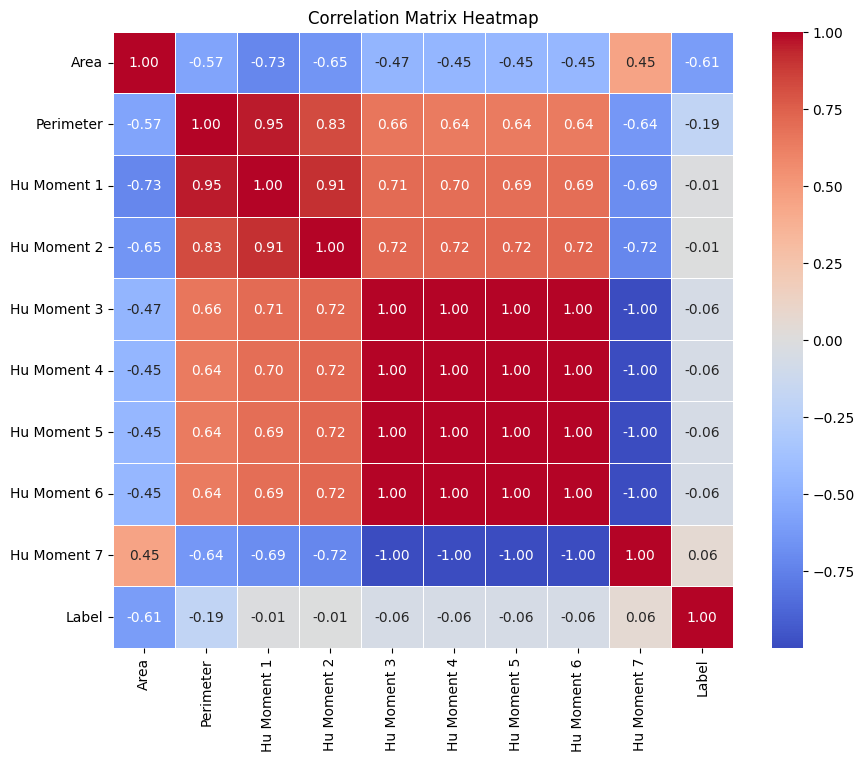

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data from Excel file
file_path = 'image_features_with_labels.csv'  # Replace 'your_excel_file.xlsx' with the path to your Excel file
data = pd.read_csv(file_path).drop(columns=["File Name"])

# Compute correlation matrix
correlation_matrix = data.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


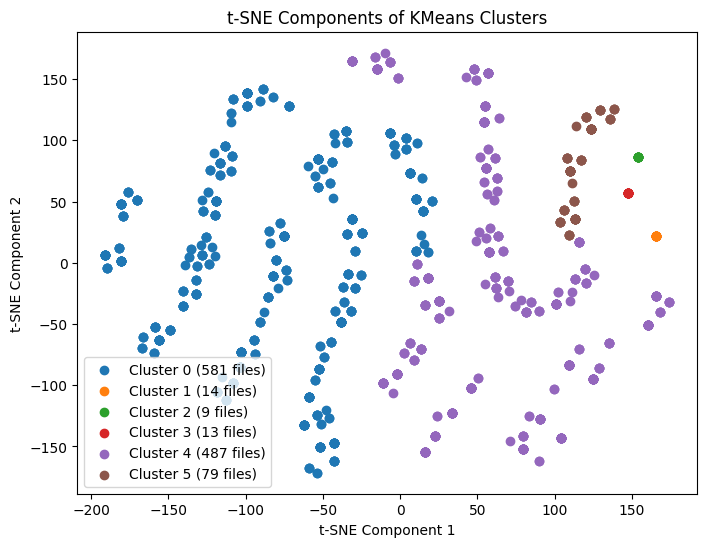

In [6]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load features and cluster labels from CSV file
def load_data_from_csv(csv_file_path):
    features = []
    cluster_labels = []
    with open(csv_file_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header row
        for row in reader:
            features.append(list(map(float, row[1:])))  # Features are from second column onwards
            cluster_labels.append(int(row[10]))  # First column contains cluster labels
    return np.array(features), np.array(cluster_labels)

# Path to CSV file containing KMeans cluster labels
csv_file_path = "image_features_with_labels.csv"

# Load features and cluster labels
features, cluster_labels = load_data_from_csv(csv_file_path)

# Perform t-SNE to reduce dimensionality to 2 components
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(features)

# Count the number of files in each cluster
cluster_counts = {cluster_label: np.sum(cluster_labels == cluster_label) for cluster_label in set(cluster_labels)}

# Plot t-SNE components with cluster labels
plt.figure(figsize=(8, 6))
for cluster_label in range(max(cluster_labels) + 1):
    plt.scatter(X_tsne[cluster_labels == cluster_label, 0], X_tsne[cluster_labels == cluster_label, 1], label=f'Cluster {cluster_label} ({cluster_counts[cluster_label]} files)')
plt.title('t-SNE Components of KMeans Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()


What we are going to do next is that we will re-run the k-means on the Cluster0 subcategory and see if again some clusters are formed or not

In [9]:
import csv
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

def is_image_file(file_path):
  """Checks if the given path points to an image file.

  Args:
      file_path: Path to the file.

  Returns:
      True if the path points to an image file, False otherwise.
  """

  # Get the file extension
  ext = os.path.splitext(file_path)[1].lower()
  # Define a list of common image extensions
  image_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".gif"]
  return ext in image_extensions

def extract_features(image_path):
    """Extracts shape features from an image.

    Args:
        image_path: Path to the image file.

    Returns:
        A list of features, including area, perimeter, and Hu moments.
    """

    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Edge detection
    edges = cv2.Canny(gray, 100, 200)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    features = []
    for cntr in contours:
        # Area
        area = cv2.contourArea(cntr)

        # Perimeter
        perimeter = cv2.arcLength(cntr, True)

        # Hu moments
        moments = cv2.moments(cntr)
        hu_moments = cv2.HuMoments(moments).flatten()

        # Combine features
        features.append([area, perimeter, *hu_moments])

    return features



def process_image_folder(folder_path):
    """Extracts features from all images in a folder.

    Args:
        folder_path: Path to the folder containing images.

    Returns:
        A list of features for all images in the folder.
    """

    all_features = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if is_image_file(file_path):  # Use the function from previous explanation
            features = extract_features(file_path)
            if features is not None:
                all_features.extend(features)  # Combine features from all images
    return all_features

def save_features_to_csv(features, labels,file_names, output_file_path):
    """Saves extracted features and predicted labels to a CSV file."""
    with open(output_file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)

        # Write header row with feature names and label
        feature_names = ["File Name", "Area", "Perimeter", "Hu Moment 1", "Hu Moment 2", "Hu Moment 3", "Hu Moment 4", "Hu Moment 5", "Hu Moment 6", "Hu Moment 7","Label"]
        writer.writerow(feature_names)

        # Write each image's features and label as a row
        for file_name, image_features, label in zip(file_names, features, labels):
            row = [file_name] + image_features + [label]
            writer.writerow(row)


def main():
    # Image folder path
    image_folder_path = "resized_images/Cluster_0"  # Replace with your actual path
    output_csv_file = "image_features_with_labels_Cluster_0.csv"

    # Extract features from all images in the folder
    all_features = process_image_folder(image_folder_path)
    all_file_names = [file_name for file_name in os.listdir(image_folder_path) if is_image_file(os.path.join(image_folder_path, file_name))]
    # K-Means clustering
    desired_number_of_clusters = 92 # Adjust based on your understanding of image families

    # Train on all data
    kmeans = KMeans(n_clusters=desired_number_of_clusters, n_init='auto')

    kmeans.fit(all_features)

    # Predict clusters for all images
    all_cluster_labels = kmeans.predict(all_features)

    # Save features and labels to CSV
    save_features_to_csv(all_features, all_cluster_labels, all_file_names, output_csv_file)
    print("Features, file names, and labels saved to CSV file:", output_csv_file)

if __name__ == "__main__":
    main()


Features, file names, and labels saved to CSV file: image_features_with_labels_Cluster_0.csv


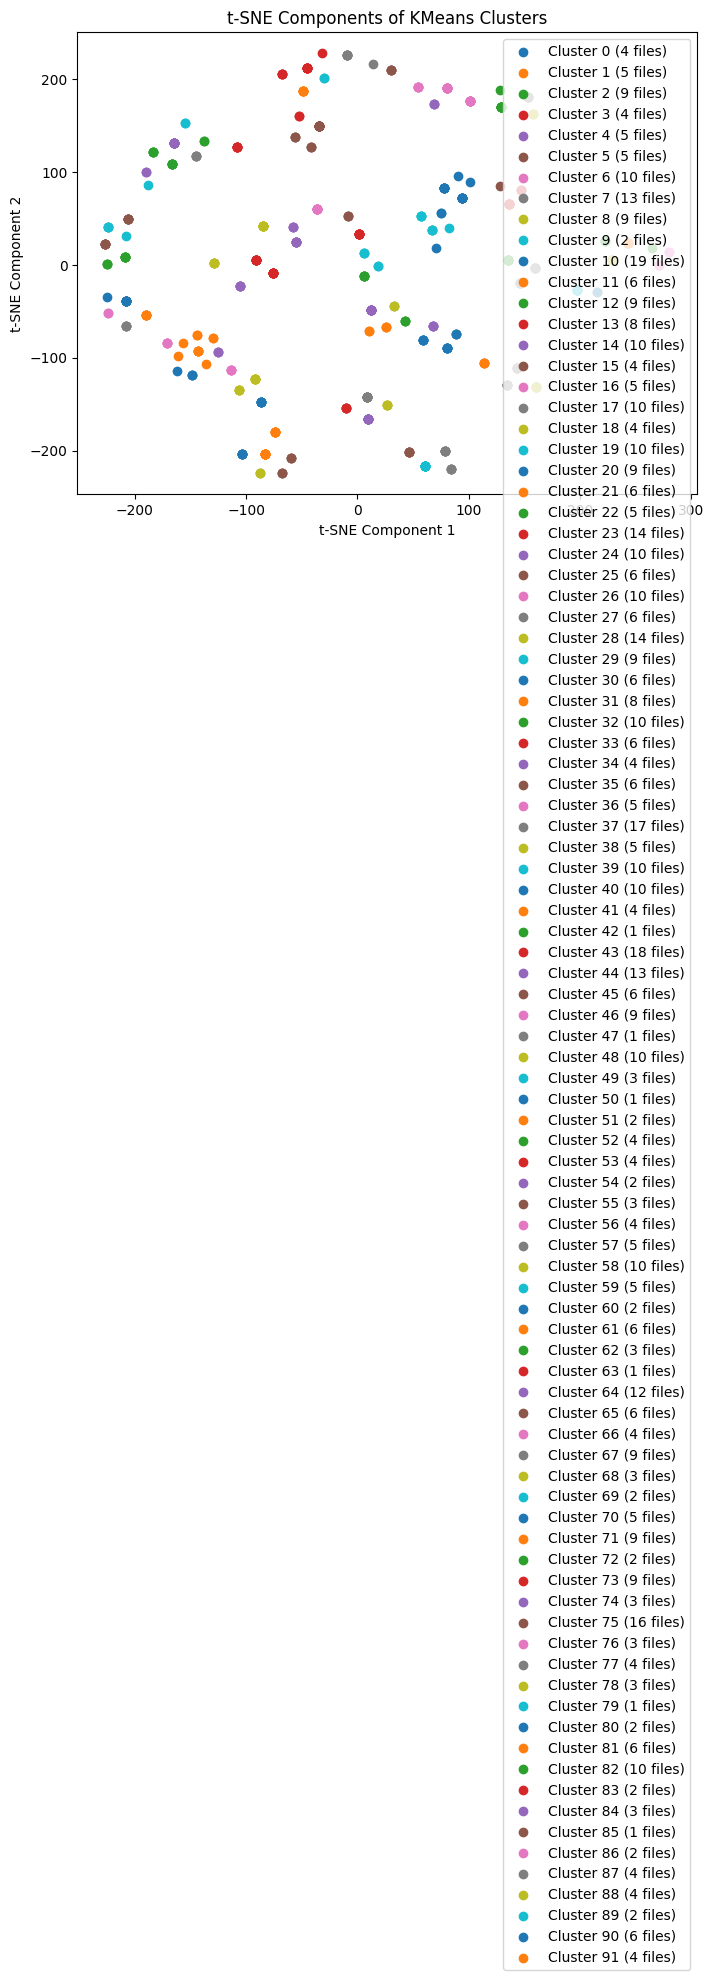

In [10]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load features and cluster labels from CSV file
def load_data_from_csv(csv_file_path):
    features = []
    cluster_labels = []
    with open(csv_file_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header row
        for row in reader:
            features.append(list(map(float, row[1:])))  # Features are from second column onwards
            cluster_labels.append(int(row[10]))  # Last column contains cluster labels
    return np.array(features), np.array(cluster_labels)

# Path to CSV file containing KMeans cluster labels
csv_file_path = "image_features_with_labels_Cluster_0.csv"

# Load features and cluster labels
features, cluster_labels = load_data_from_csv(csv_file_path)

# Perform t-SNE to reduce dimensionality to 2 components
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(features)

# Count the number of files in each cluster
cluster_counts = {cluster_label: np.sum(cluster_labels == cluster_label) for cluster_label in set(cluster_labels)}

# Plot t-SNE components with cluster labels
plt.figure(figsize=(8, 6))
for cluster_label in range(max(cluster_labels) + 1):
    plt.scatter(X_tsne[cluster_labels == cluster_label, 0], X_tsne[cluster_labels == cluster_label, 1], label=f'Cluster {cluster_label} ({cluster_counts[cluster_label]} files)')
plt.title('t-SNE Components of KMeans Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()


After creating these 100 clusters and downloading the entire directory, we found that in thoose 100 sub directories, in each subdirectory we got around 7-8 images which were present with different names but were exactly similar. So now we will create a different notebook which will 1st remove all duplicates then run the k-means

In [11]:
import os
import shutil
import csv

# Function to move images to cluster subfolders based on cluster labels
def move_images_to_clusters(image_folder_path, csv_file_path):
    # Create cluster subfolders
    for i in range(desired_number_of_clusters):
        cluster_folder_path = os.path.join(image_folder_path, f"Cluster_{i}")
        os.makedirs(cluster_folder_path, exist_ok=True)

    # Read CSV file
    with open(csv_file_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header row
        for row in reader:
            file_name = row[0]
            cluster_label = row[-1]  # Assuming cluster label is in the last column
            source_path = os.path.join(image_folder_path, file_name)
            destination_path = os.path.join(image_folder_path, f"Cluster_{cluster_label}", file_name)
            shutil.move(source_path, destination_path)

# Example usage
image_folder_path = "resized_images/Cluster_0"
csv_file_path = "image_features_with_labels_Cluster_0.csv"
desired_number_of_clusters = 92

move_images_to_clusters(image_folder_path, csv_file_path)


In [12]:
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'directory.zip'):
    """
    zip all the files in a directory
    
    Parameters
    _____
    directory: str
        directory needs to be zipped, defualt is current working directory
        
    file_name: str
        the name of the zipped file (including .zip), default is 'directory.zip'
        
    Returns
    _____
    Creates a hyperlink, which can be used to download the zip file)
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

In [13]:
zip_dir()

c:\Users\Pratyush Ranjan\Desktop\Group_29\directory.zip